# Output summaries of datatset 

I need to get a handle on how many full genomes I have from different countries, domestic/wild statuses, etc... I can sort of get an idea of this by looking at the tree, but it would be good to have some actual numbers. In this notebook, I would like to do the following: 

1. group strains to select out ones that have full genomes vs. do not. 
2. plot the distribution of genomes from domestic and wild birds for different geographic areas

In [1]:
# using the Entrez feature from bio
from Bio import SeqIO
import re
import time, datetime
import pandas as pd
import numpy as np
import rpy2
%load_ext rpy2.ipython

# Read in full genomes metadata files

I have subsetted down my data to include only full genome sequences. I would now like to read in those files and output some summary statistics about our representation of geographic region, host species, and time

In [2]:
def read_metadata_file(metadata_file, output_dict):

    with open(metadata_file, "r") as infile: 
        for line in infile: 
            if "originating_lab" not in line:
                strain = line.split("\t")[0]
                accession = line.split("\t")[2]
                date = line.split("\t")[3]
                region = line.split("\t")[4]
                country = line.split("\t")[5]
                host_group = line.split("\t")[8].lower()
                domestic_wild = line.split("\t")[13]
                annotation_method = line.split("\t")[14]
                genbank_id = line.split("\t")[15]
                
                
                if strain not in output_dict:
                    output_dict[strain] = {"accessions":[accession],"date":date, "region":region, "country":country,
                                       "domestic_wild":domestic_wild,"host_group":host_group, 
                                       "annotation_method":annotation_method,"genbank_id":[genbank_id]}
                else:
                    output_dict[strain]['accessions'].append(accession)
                    output_dict[strain]['genbank_id'].append(genbank_id)

    return(output_dict)

In [3]:
metadata_directory = "/Users/lmoncla/src/h5n1-host-classification/metadata-with-annotations/"
genes = ['pb2','pb1','pa','ha','np','na','mp','ns']
all_full_genomes_dict = {}

for g in genes: 
    metadata_file = metadata_directory + "metadata_h5n1_"+g+"-full-genomes-only-2020-10-07.txt"
    all_full_genomes_dict = read_metadata_file(metadata_file, all_full_genomes_dict)

In [4]:
print(len(all_full_genomes_dict))

4211


# Output summaries

Now that I have a list of strains that have complete genomes, I can output some stats on how many of those have full annotations

In [5]:
def output_number_domestic_wild(input_dict):
    
    domestic = 0
    wild = 0
    human = 0
    other = 0
    not_classified = 0
    
    for strain in input_dict: 
        domestic_wild = input_dict[strain]['domestic_wild']
        if domestic_wild == "human":
            human += 1
        elif domestic_wild == "wild":
            wild += 1
        elif domestic_wild == "domestic":
            domestic += 1
        elif domestic_wild == "":
            not_classified += 1
        else: 
            other += 1
            
    return(domestic, wild, human, other, not_classified)

In [6]:
def output_number_per_geo(input_dict):
    regions = {}
    countries = {}
    
    for strain in input_dict: 
        region = input_dict[strain]['region']
        country = input_dict[strain]['country']
        
        if region not in regions: 
            regions[region] = 1
        else:
            regions[region] += 1
        
        if country not in countries: 
            countries[country] = 1
        else:
            countries[country] += 1
    
    return(regions, countries)

In [7]:
def return_dates(input_dict):
    years = {}
    
    for strain in input_dict: 
        date = input_dict[strain]['date']
        year = int(date[0:4])
        date_resolution = return_date_resolution(date)
        
        if year not in years: 
            years[year] = {"total": 1, date_resolution: 1}
        else:
            years[year]["total"] += 1
            
            if date_resolution not in years[year]:
                years[year][date_resolution] = 1
            else:
                years[year][date_resolution] += 1
            
    return(years)

In [19]:
def return_dates_and_host(input_dict):
    
    date_resolution_by_host = {"human":{}, "domestic":{}, "wild":{}}
    
    for strain in input_dict: 
        host_group = input_dict[strain]['domestic_wild']
        
        if host_group in ['human','domestic','wild']: # if you are a host group we want
            date = input_dict[strain]['date']
            year = int(date[0:4])
            date_resolution = return_date_resolution(date)

            if year not in date_resolution_by_host[host_group]:
                date_resolution_by_host[host_group][year] = {}

            if date_resolution not in date_resolution_by_host[host_group][year]:
                date_resolution_by_host[host_group][year][date_resolution] = 1
            else: 
                date_resolution_by_host[host_group][year][date_resolution] += 1            
    
    return(date_resolution_by_host)

In [8]:
def return_date_resolution(date):
    date = date.replace("-XX","")
    
    if len(date) == 4:
        date_resolution = "year"
    elif len(date) == 7:
        date_resolution = "month"
    elif len(date) == 10:
        date_resolution = "day"
    else:
        print("what's up with this date ", date)
    
    return(date_resolution)

In [9]:
domestic, wild, human, other, not_classified = output_number_domestic_wild(all_full_genomes_dict)
print(domestic, wild, human, other, not_classified)

2085 441 314 375 996


In [10]:
dates = return_dates(all_full_genomes_dict)
dates_df = pd.DataFrame.from_dict(dates, orient="index")
dates_df.reset_index(inplace=True)
dates_df = dates_df.fillna(0)
dates_df

,index,total,day,month,year
0,1996,1,0.0,0.0,1.0
1,1997,31,0.0,0.0,31.0
2,1998,1,0.0,0.0,1.0
3,1999,7,0.0,0.0,7.0
4,2000,19,0.0,0.0,19.0
5,2001,60,0.0,0.0,60.0
6,2002,63,0.0,0.0,63.0
7,2003,102,10.0,0.0,92.0
8,2004,241,15.0,0.0,226.0
9,2005,376,51.0,0.0,325.0


In [13]:
regions,countries = output_number_per_geo(all_full_genomes_dict)
regions

{'North America': 67,
 'Europe': 113,
 'China': 1079,
 'Southeast Asia': 1719,
 'South Asia': 344,
 'West Asia': 130,
 '?': 16,
 'Africa': 602,
 'Japan Korea': 141}

In [14]:
countries

{'Canada': 4,
 'USA': 63,
 'Belgium': 2,
 'Slovenia': 3,
 'China': 910,
 'Vietnam': 1187,
 'Bangladesh': 198,
 'Cambodia': 129,
 'Sweden': 10,
 'Thailand': 122,
 'Indonesia': 220,
 'Hong Kong': 164,
 'Laos': 45,
 'Turkey': 15,
 '?': 16,
 'Germany': 37,
 'Russia': 57,
 'Czech Republic': 6,
 'United Arab Emirates': 7,
 'Egypt': 209,
 'South Korea': 52,
 'Burkina Faso': 14,
 'Iraq': 1,
 'Taiwan': 1,
 'Slovakia': 2,
 'Nepal': 1,
 'Mongolia': 13,
 'Japan': 89,
 'Togo': 3,
 'Tibet': 4,
 'Denmark': 9,
 'Poland': 10,
 'Afghanistan': 5,
 'India': 92,
 'Benin': 1,
 'Bhutan': 53,
 'Cameroon': 10,
 'Cote D Ivoire': 9,
 'Ukraine': 2,
 'France': 13,
 'Palestine': 2,
 'Ghana': 28,
 'Myanmar': 14,
 'Iran': 2,
 'Israel': 4,
 'Kuwait': 8,
 'Pakistan': 3,
 'Lebanon': 2,
 'Malaysia': 2,
 'Niger': 10,
 'Nigeria': 311,
 'Croatia': 2,
 'Saudi Arabia': 9,
 'United Kingdom': 5,
 'Sudan': 6,
 'Bulgaria': 1,
 'Italy': 4,
 'Kazakhstan': 2,
 'Hungary': 6,
 'South Africa': 1,
 'Netherlands': 1}

## Initial thoughts

So upon initial inspection, it seems like for full genomes, we have a pretty good selection in terms of years, regions, and countries. Domestic poultry are really over-represented. However, we probably don't want to be trying to run a 4000 tip tree in beast anyway, so I think that it will be ok to subsampled down domestic sequences. I think that the thing I have been doing in augur filter where I filter by country, year, and domestic wild will be a good way to go. 

# Plot

I'd now like to do some plotting

In [11]:
df = pd.DataFrame.from_dict(all_full_genomes_dict, orient="index")
df.reset_index(inplace=True)
df = df[["index","date","region","country","domestic_wild","host_group","annotation_method"]]
df.head()

,index,date,region,country,domestic_wild,host_group,annotation_method
0,A/Alberta/1/2014,2014-01-03,North America,Canada,human,human,
1,A/Americanblackduck/Alberta/118/2016,2016-08-11,North America,Canada,wild,avian,species name
2,A/Americangreen-wingedteal/Washington/195750/2014,2014-12-29,North America,USA,wild,avian,species name
3,A/Americanwigeon/Washington/196336/2015,2015-01-02,North America,USA,wild,avian,species name
4,A/Americanwigeon/Washington/196340/2015,2015-01-02,North America,USA,wild,avian,species name


In [12]:
len(df)

4211

In [13]:
# keep only domestic, wild, and human 
df = df[df['domestic_wild'].isin(['domestic','wild','human'])]
df['year'] = df['date'].str.split("-", expand=True)[0]
df.head()

,index,date,region,country,domestic_wild,host_group,annotation_method,year
0,A/Alberta/1/2014,2014-01-03,North America,Canada,human,human,,2014
1,A/Americanblackduck/Alberta/118/2016,2016-08-11,North America,Canada,wild,avian,species name,2016
2,A/Americangreen-wingedteal/Washington/195750/2014,2014-12-29,North America,USA,wild,avian,species name,2014
3,A/Americanwigeon/Washington/196336/2015,2015-01-02,North America,USA,wild,avian,species name,2015
4,A/Americanwigeon/Washington/196340/2015,2015-01-02,North America,USA,wild,avian,species name,2015


In [14]:
output_directory = "/Users/lmoncla/src/h5n1-host-classification/figures"

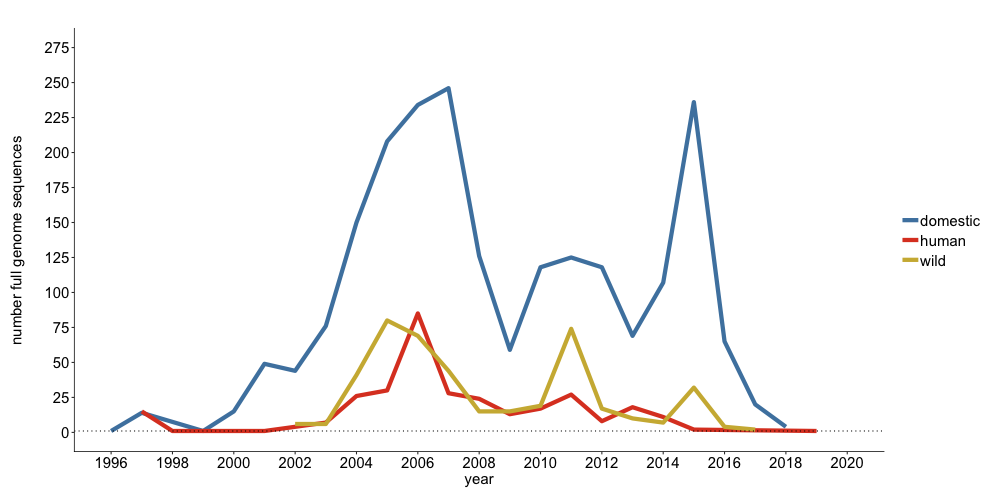

In [16]:
%%R -w 1000 -h 500 -u px -i df,output_directory  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

df$date = as.Date(df$date)
df$year = as.numeric(df$year)
p <- ggplot(data=df, aes(x=year, group=domestic_wild, color=domestic_wild)) + 
    geom_line(stat="count", size=2)+
    geom_hline(yintercept=1, linetype = 3)+
    #geom_vline(xintercept=vlines1, size=0.8, linetype='dashed', color = '#808080')+
    labs(x="year",y="number full genome sequences")+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_colour_manual(values=c(domestic="#4E83AE",wild="#CEB540", human="#DE4428"))+
    scale_y_continuous(limits=c(0,275), breaks=seq(0,275,25))+
    scale_x_continuous(limits=c(1996,2020), breaks=seq(0,2020,2))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=15))+
    theme(axis.title.y=element_text(size=15, vjust=8))+
    theme(axis.title.x=element_text(size=15))+
    theme(axis.text=element_text(size=15, colour="black"))+
    theme(legend.text=element_text(size=15))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1.0,0.5,0.5,1.0),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("available-seqs-per-year-host-2020-10-14.pdf", p, width = 12, height = 5, path=output_directory)
p

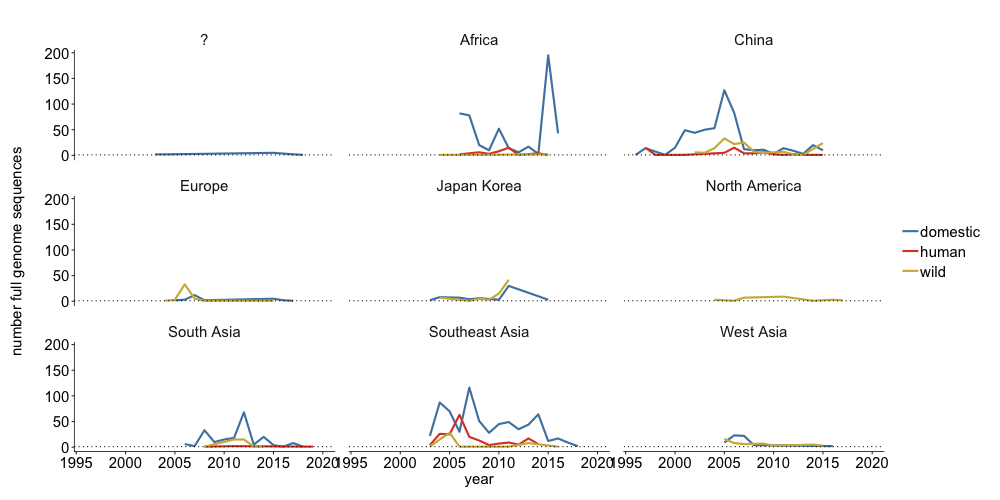

In [17]:
%%R -w 1000 -h 500 -u px -i df,output_directory  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

df$date = as.Date(df$date)
df$year = as.numeric(df$year)

p <- ggplot(data=df, aes(x=year, group=domestic_wild, color=domestic_wild)) + 
    geom_line(stat="count", size=1)+
    geom_hline(yintercept=1, linetype = 3)+
    facet_wrap(~region)+
    #geom_vline(xintercept=vlines1, size=0.8, linetype='dashed', color = '#808080')+
    labs(x="year",y="number full genome sequences")+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_colour_manual(values=c(domestic="#4E83AE",wild="#CEB540", human="#DE4428"))+
    ##scale_y_continuous(limits=c(0,275), breaks=seq(0,275,25))+
    scale_x_continuous(limits=c(1996,2020), breaks=seq(0,2020,5))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=15))+
    theme(axis.title.y=element_text(size=15, vjust=8))+
    theme(axis.title.x=element_text(size=15))+
    theme(axis.text=element_text(size=15, colour="black"))+
    theme(legend.text=element_text(size=15))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1.0,0.5,0.5,1.0),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("available-seqs-per-year-region-host-2020-10-14.pdf", p, width = 16, height = 8, path=output_directory)
p

In [22]:
dates_df

,index,total,day,month,year
0,1996,1,0.0,0.0,1.0
1,1997,31,0.0,0.0,31.0
2,1998,1,0.0,0.0,1.0
3,1999,7,0.0,0.0,7.0
4,2000,19,0.0,0.0,19.0
5,2001,60,0.0,0.0,60.0
6,2002,63,0.0,0.0,63.0
7,2003,102,10.0,0.0,92.0
8,2004,241,15.0,0.0,226.0
9,2005,376,51.0,0.0,325.0


In [50]:
dates_df_melt = dates_df.melt(id_vars=['index','total'])
dates_df_melt.head()

,index,total,variable,value
0,1996,1,day,0.0
1,1997,31,day,0.0
2,1998,1,day,0.0
3,1999,7,day,0.0
4,2000,19,day,0.0


In [35]:
output_directory = "/Users/lmoncla/src/h5n1-host-classification/figures"

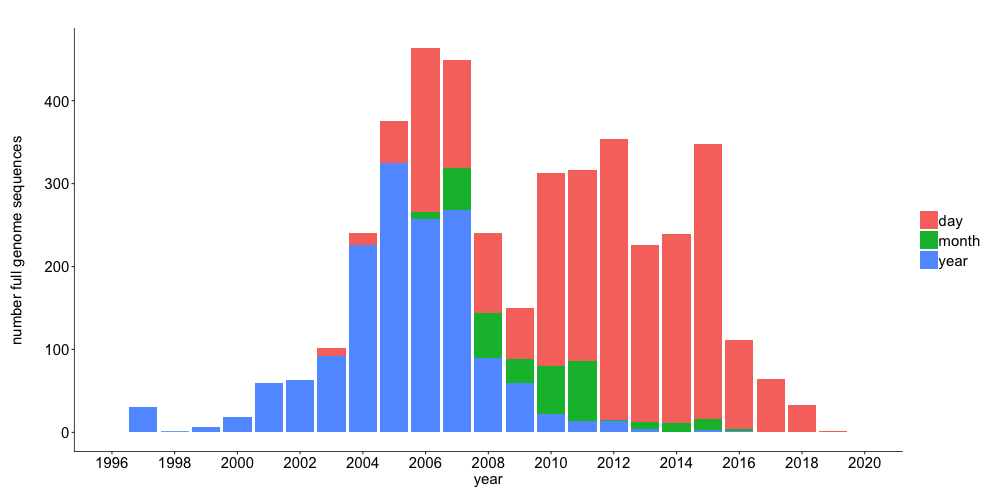

In [54]:
%%R -w 1000 -h 500 -u px -i dates_df_melt,output_directory  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

dates_df_melt$index = as.numeric(dates_df_melt$index)

p <- ggplot(data=dates_df_melt, aes(x=index, y=value, fill=variable)) + 
    geom_col()+
    #geom_vline(xintercept=vlines1, size=0.8, linetype='dashed', color = '#808080')+
    labs(x="year",y="number full genome sequences")+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    #scale_colour_manual(values=c("#4C9C86","#271B9C"), guide=FALSE)+
    #scale_y_continuous(limits=c(0,275), breaks=seq(0,275,25))+
    scale_x_continuous(limits=c(1996,2020), breaks=seq(0,2020,2))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=15))+
    theme(axis.title.y=element_text(size=15, vjust=8))+
    theme(axis.title.x=element_text(size=15))+
    theme(axis.text=element_text(size=15, colour="black"))+
    theme(legend.text=element_text(size=15))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1.0,0.5,0.5,1.0),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("available-seqs-per-year-date-resolution-2020-10-26.pdf", p, width = 12, height = 5, path=output_directory)
p

In [20]:
# get tthe number of genomes with date resolutions partitioned by host group 

dates_with_host = return_dates_and_host(all_full_genomes_dict)
dates_with_host

{'human': {2014: {'day': 11},
  2005: {'day': 16, 'year': 14},
  2006: {'day': 70, 'year': 15},
  2007: {'day': 25, 'year': 3},
  2008: {'month': 3, 'day': 19, 'year': 2},
  2011: {'day': 17, 'year': 10},
  2003: {'year': 3, 'day': 4},
  2010: {'day': 17},
  2012: {'day': 8},
  2013: {'day': 18},
  2009: {'day': 12, 'year': 1},
  2015: {'day': 2},
  1997: {'year': 15},
  2001: {'year': 1},
  1998: {'year': 1},
  2019: {'day': 1},
  2004: {'year': 20, 'day': 6}},
 'domestic': {2004: {'year': 145, 'day': 5},
  2013: {'day': 60, 'month': 7, 'year': 2},
  2005: {'year': 198, 'day': 10},
  1997: {'year': 14},
  2001: {'year': 49},
  2006: {'year': 161, 'day': 69, 'month': 4},
  2009: {'day': 26, 'month': 18, 'year': 15},
  2007: {'month': 10, 'year': 169, 'day': 67},
  2008: {'day': 65, 'year': 43, 'month': 18},
  2003: {'year': 73, 'day': 3},
  2002: {'year': 44},
  2000: {'year': 15},
  1996: {'year': 1},
  2011: {'month': 41, 'day': 82, 'year': 2},
  2014: {'day': 98, 'month': 9},
  2015

In [21]:
date_resolution_df = pd.DataFrame.from_dict(dates_with_host, orient="columns")
date_resolution_df = date_resolution_df.fillna(0)
date_resolution_df.reset_index(inplace=True)
date_resolution_df

,index,human,domestic,wild
0,1996,0,{'year': 1},0
1,1997,{'year': 15},{'year': 14},0
2,1998,{'year': 1},0,0
3,1999,0,{'year': 1},0
4,2000,0,{'year': 15},0
5,2001,{'year': 1},{'year': 49},0
6,2002,0,{'year': 44},{'year': 6}
7,2003,"{'year': 3, 'day': 4}","{'year': 73, 'day': 3}","{'year': 4, 'day': 2}"
8,2004,"{'year': 20, 'day': 6}","{'year': 145, 'day': 5}","{'year': 37, 'day': 4}"
9,2005,"{'day': 16, 'year': 14}","{'year': 198, 'day': 10}","{'year': 73, 'day': 7}"
